In [55]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

tf.random.set_seed(1)

In [56]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

In [57]:
def loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['mse_loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['kl_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','mse_loss','val_loss','kl_loss'])

In [58]:
height,width=64,64

train_buffer=60000
test_buffer=10000

batch_size=10
latent_dimensions=12

num=4000
comps=2

beta=0.1

In [59]:
together=np.array((np.load('central_blends.npy'),np.load('central_components.npy')))
blended,components=together[0],together[1]
together.shape,blended.shape,components.shape

#validation=np.load('blend_test.npy')
#blended_v,components_v=validation[0],np.array((validation[1],validation[2]))
#blended_v.shape,components_v.shape

C:\Users\Tim\AppData\Local\Temp/ipykernel_1036/834354158.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  together=np.array((np.load('central_blends.npy'),np.load('central_components.npy')))


((2,), (4000, 64, 64), (2, 4000, 64, 64))

In [60]:
blends_max=np.amax(blended)
blends_min=np.amin(blended)
comp_max=np.amax(components)
comp_min=np.amin(components)

blended-=blends_min
blended/=blends_max
components-=comp_min
components/=comp_max

blended=blended.reshape(blended.shape[0],height,width,1).astype('float32')
components=components.reshape(2,blended.shape[0],height,width,1).astype('float32')
#blended_v=blended_v.reshape(blended_v.shape[0],height,width,1).astype('float32')
#components_v=components_v.reshape(2,blended_v.shape[0],height,width,1).astype('float32')

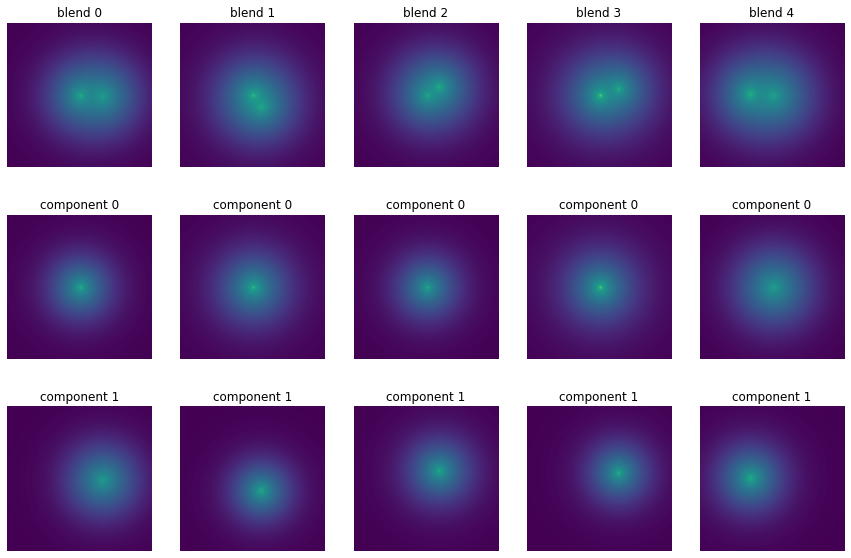

In [61]:
n=5
fig,ax=plt.subplots(3,n,figsize=(3*n, 10))
for i in range(n):
    showimg(blended[i],ax[0,i],f'blend {i}')
    for j in range(comps):
        showimg(components[j,i],ax[j+1,i],f'component {j}')  

In [62]:
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    return x

In [63]:
def decoder(x):
    x=UpSampling2D(size=(2,2))(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [64]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [65]:
#encoder
inputs=Input(shape=(height,width,1))

encoded=encoder(inputs)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

#decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

In [66]:
encode=Model(inputs,z)
encode.summary()

decode=Model([input_embed],[output1])
decode.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 32, 32)   320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 16, 16, 32)   9248        conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 8, 8, 64)     18496       conv2d_17[0][0]                  
______________________________________________________________________________________

In [67]:
encoding=encode(inputs) #define the network
re=decode([encoding])

vae=Model([inputs],[re]) #adds methods of the network
vae.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
functional_21 (Functional)   (None, 12)                71160     
_________________________________________________________________
functional_23 (Functional)   (None, 64, 64, 1)         105185    
Total params: 176,345
Trainable params: 176,345
Non-trainable params: 0
_________________________________________________________________


In [68]:
mse_loss=tf.reduce_mean(mse(inputs,re))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

vae.compile(optimizer=Adam(learning_rate=0.001))

In [69]:
history=vae.fit(components[0],verbose=1,epochs=100,batch_size=batch_size,validation_split=0.1)

Epoch 1/100
360/360 [==============================] - 10s 27ms/step - loss: 4.4163 - mse_loss: 4.1559 - kl_loss: 0.2603 - val_loss: 0.6298 - val_mse_loss: 0.4209 - val_kl_loss: 0.2090
Epoch 2/100
360/360 [==============================] - 10s 27ms/step - loss: 0.4123 - mse_loss: 0.2219 - kl_loss: 0.1904 - val_loss: 0.3376 - val_mse_loss: 0.1642 - val_kl_loss: 0.1734
Epoch 3/100
360/360 [==============================] - 9s 26ms/step - loss: 0.3344 - mse_loss: 0.1738 - kl_loss: 0.1606 - val_loss: 0.2821 - val_mse_loss: 0.1296 - val_kl_loss: 0.1524
Epoch 4/100
360/360 [==============================] - 10s 26ms/step - loss: 0.2916 - mse_loss: 0.1478 - kl_loss: 0.1437 - val_loss: 0.2787 - val_mse_loss: 0.1404 - val_kl_loss: 0.1383
Epoch 5/100
360/360 [==============================] - 9s 26ms/step - loss: 0.2739 - mse_loss: 0.1433 - kl_loss: 0.1307 - val_loss: 0.3627 - val_mse_loss: 0.2439 - val_kl_loss: 0.1188
Epoch 6/100
360/360 [==============================] - 9s 26ms/step - loss: 0

360/360 [==============================] - 9s 26ms/step - loss: 0.0930 - mse_loss: 0.0523 - kl_loss: 0.0407 - val_loss: 0.1340 - val_mse_loss: 0.0928 - val_kl_loss: 0.0412
Epoch 46/100
360/360 [==============================] - 9s 26ms/step - loss: 0.0801 - mse_loss: 0.0404 - kl_loss: 0.0397 - val_loss: 0.1069 - val_mse_loss: 0.0644 - val_kl_loss: 0.0425
Epoch 47/100
360/360 [==============================] - 9s 26ms/step - loss: 0.0786 - mse_loss: 0.0396 - kl_loss: 0.0390 - val_loss: 0.0747 - val_mse_loss: 0.0348 - val_kl_loss: 0.0399
Epoch 48/100
360/360 [==============================] - 9s 26ms/step - loss: 0.0843 - mse_loss: 0.0460 - kl_loss: 0.0384 - val_loss: 0.0872 - val_mse_loss: 0.0453 - val_kl_loss: 0.0419
Epoch 49/100
360/360 [==============================] - 9s 26ms/step - loss: 0.0758 - mse_loss: 0.0377 - kl_loss: 0.0381 - val_loss: 0.0705 - val_mse_loss: 0.0301 - val_kl_loss: 0.0405
Epoch 50/100
360/360 [==============================] - 9s 26ms/step - loss: 0.0760 - ms

360/360 [==============================] - 10s 26ms/step - loss: 0.0669 - mse_loss: 0.0316 - kl_loss: 0.0353 - val_loss: 0.0646 - val_mse_loss: 0.0294 - val_kl_loss: 0.0352
Epoch 90/100
360/360 [==============================] - 9s 26ms/step - loss: 0.0654 - mse_loss: 0.0303 - kl_loss: 0.0351 - val_loss: 0.0744 - val_mse_loss: 0.0373 - val_kl_loss: 0.0371
Epoch 91/100
360/360 [==============================] - 10s 27ms/step - loss: 0.0640 - mse_loss: 0.0290 - kl_loss: 0.0350 - val_loss: 0.0722 - val_mse_loss: 0.0361 - val_kl_loss: 0.0361
Epoch 92/100
360/360 [==============================] - 9s 26ms/step - loss: 0.0662 - mse_loss: 0.0308 - kl_loss: 0.0353 - val_loss: 0.0578 - val_mse_loss: 0.0223 - val_kl_loss: 0.0355
Epoch 93/100
360/360 [==============================] - 10s 27ms/step - loss: 0.0663 - mse_loss: 0.0314 - kl_loss: 0.0349 - val_loss: 0.0693 - val_mse_loss: 0.0340 - val_kl_loss: 0.0353
Epoch 94/100
360/360 [==============================] - 9s 26ms/step - loss: 0.0662 -

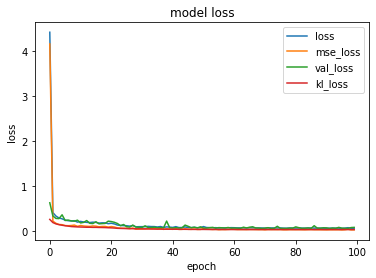

In [70]:
loss_plot(history)

In [71]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z])
    fig, ax = plt.subplots(3, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(output_img[i], ax[1, i], f'output\n{encoding}')
        showimg(output_img[i]-input_img[i], ax[2, i], f'output difference')
    return idx

[24 39 52 27 44]


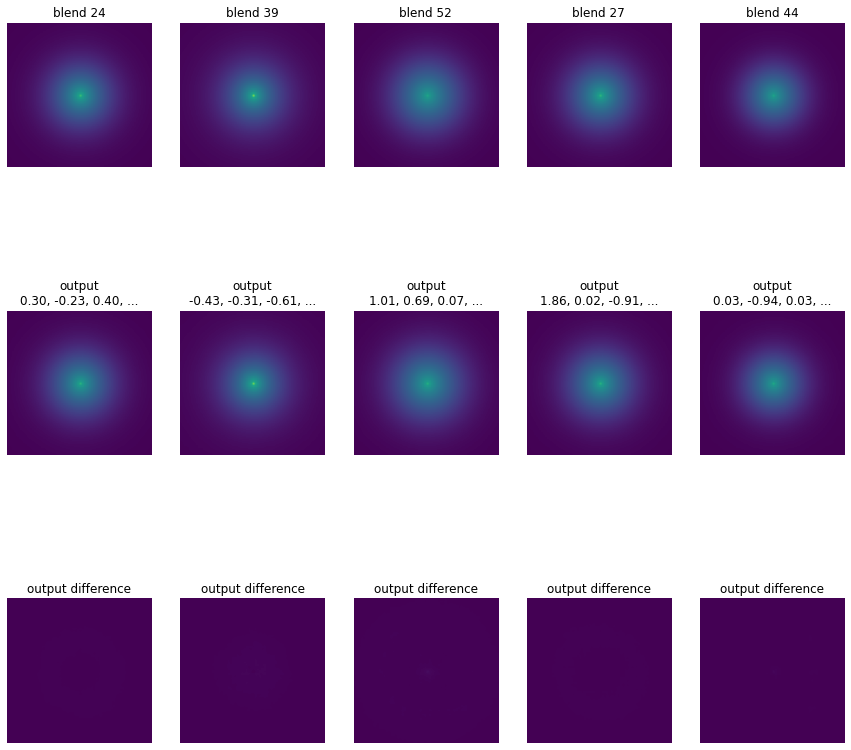

In [72]:
chosen=summary_plot(n,components[0],decode)

In [73]:
#encoder2
inputs2=Input(shape=(height,width,1))

encoded2=encoder(inputs2)
shape=encoded2.get_shape()[1:]
encoded2=Flatten()(encoded2)

z_mean2=Dense(latent_dimensions)(encoded2)
z_log_sigma2=Dense(latent_dimensions)(encoded2)
z2=Lambda(sampling)([z_mean2,z_log_sigma2])

In [74]:
encode2=Model(inputs2,z2)
encode2.summary()

input_compc=Input(shape=(height,width,1))

for layer in decode.layers:
    layer.trainable=False

decode.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 32, 32)   320         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 16, 16, 32)   9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 8, 8, 64)     18496       conv2d_21[0][0]                  
______________________________________________________________________________________

In [75]:
encoding2=encode2(inputs2) #define the network
re2=decode([encoding2])

vae=Model([inputs2,input_compc],[re2]) #adds methods of the network
vae.summary()

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
functional_27 (Functional)      (None, 12)           71160       input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
functional_23 (Functional)      (None, 64, 64, 1)    105185      functional_27[0][0]              
Total params: 176,345
Trainable params: 71,160
Non-trainable params: 105,185
_________

In [76]:
mse_loss=tf.reduce_mean(mse(input_compc,re2))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma2-tf.square(z_mean2)-tf.exp(z_log_sigma2)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

together=[blended,components[0]]
#together_v=[blended_v,components_v[0]]

vae.compile(optimizer=Adam(learning_rate=0.001))

In [77]:
history=vae.fit(together,verbose=1,epochs=100,batch_size=batch_size,validation_split=0.1)

Epoch 1/100
360/360 [==============================] - 8s 22ms/step - loss: 0.9975 - mse_loss: 0.9684 - kl_loss: 0.0291 - val_loss: 0.7303 - val_mse_loss: 0.6978 - val_kl_loss: 0.0325
Epoch 2/100
360/360 [==============================] - 8s 21ms/step - loss: 0.7490 - mse_loss: 0.7174 - kl_loss: 0.0316 - val_loss: 0.7505 - val_mse_loss: 0.7266 - val_kl_loss: 0.0239
Epoch 3/100
360/360 [==============================] - 8s 22ms/step - loss: 0.6937 - mse_loss: 0.6613 - kl_loss: 0.0323 - val_loss: 0.6748 - val_mse_loss: 0.6411 - val_kl_loss: 0.0337
Epoch 4/100
360/360 [==============================] - 8s 21ms/step - loss: 0.6626 - mse_loss: 0.6307 - kl_loss: 0.0320 - val_loss: 0.6629 - val_mse_loss: 0.6270 - val_kl_loss: 0.0358
Epoch 5/100
360/360 [==============================] - 8s 21ms/step - loss: 0.6602 - mse_loss: 0.6279 - kl_loss: 0.0323 - val_loss: 0.7056 - val_mse_loss: 0.6739 - val_kl_loss: 0.0317
Epoch 6/100
360/360 [==============================] - 8s 21ms/step - loss: 0.62

360/360 [==============================] - 8s 22ms/step - loss: 0.2545 - mse_loss: 0.2199 - kl_loss: 0.0346 - val_loss: 0.2583 - val_mse_loss: 0.2242 - val_kl_loss: 0.0341
Epoch 46/100
360/360 [==============================] - 8s 22ms/step - loss: 0.2351 - mse_loss: 0.2012 - kl_loss: 0.0340 - val_loss: 0.2749 - val_mse_loss: 0.2385 - val_kl_loss: 0.0364
Epoch 47/100
360/360 [==============================] - 8s 22ms/step - loss: 0.2433 - mse_loss: 0.2078 - kl_loss: 0.0356 - val_loss: 0.2587 - val_mse_loss: 0.2230 - val_kl_loss: 0.0357
Epoch 48/100
360/360 [==============================] - 8s 22ms/step - loss: 0.2343 - mse_loss: 0.1991 - kl_loss: 0.0353 - val_loss: 0.2982 - val_mse_loss: 0.2638 - val_kl_loss: 0.0344
Epoch 49/100
360/360 [==============================] - 8s 22ms/step - loss: 0.2317 - mse_loss: 0.1971 - kl_loss: 0.0346 - val_loss: 0.2583 - val_mse_loss: 0.2210 - val_kl_loss: 0.0374
Epoch 50/100
360/360 [==============================] - 8s 22ms/step - loss: 0.2273 - ms

360/360 [==============================] - 8s 22ms/step - loss: 0.1829 - mse_loss: 0.1475 - kl_loss: 0.0354 - val_loss: 0.2749 - val_mse_loss: 0.2397 - val_kl_loss: 0.0352
Epoch 90/100
360/360 [==============================] - 8s 22ms/step - loss: 0.1811 - mse_loss: 0.1462 - kl_loss: 0.0349 - val_loss: 0.2796 - val_mse_loss: 0.2437 - val_kl_loss: 0.0359
Epoch 91/100
360/360 [==============================] - 8s 22ms/step - loss: 0.1797 - mse_loss: 0.1444 - kl_loss: 0.0353 - val_loss: 0.2561 - val_mse_loss: 0.2197 - val_kl_loss: 0.0364
Epoch 92/100
360/360 [==============================] - 8s 22ms/step - loss: 0.1765 - mse_loss: 0.1414 - kl_loss: 0.0352 - val_loss: 0.2499 - val_mse_loss: 0.2137 - val_kl_loss: 0.0362
Epoch 93/100
360/360 [==============================] - 8s 22ms/step - loss: 0.1810 - mse_loss: 0.1461 - kl_loss: 0.0349 - val_loss: 0.2502 - val_mse_loss: 0.2148 - val_kl_loss: 0.0354
Epoch 94/100
360/360 [==============================] - 8s 22ms/step - loss: 0.1795 - ms

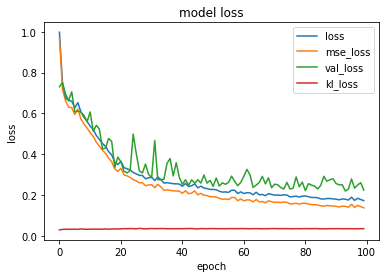

In [78]:
loss_plot(history)

In [79]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    compc=inputs[1][idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z,compc])
    fig, ax = plt.subplots(4, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(compc[i], ax[1, i], f'comp1 {idx[i]}')
        showimg(output_img[i], ax[2, i], f'output\n{encoding}')
        showimg(output_img[i]-compc[i], ax[3, i], f'output difference')
    return idx

[ 200 1078  610 2159 1169]


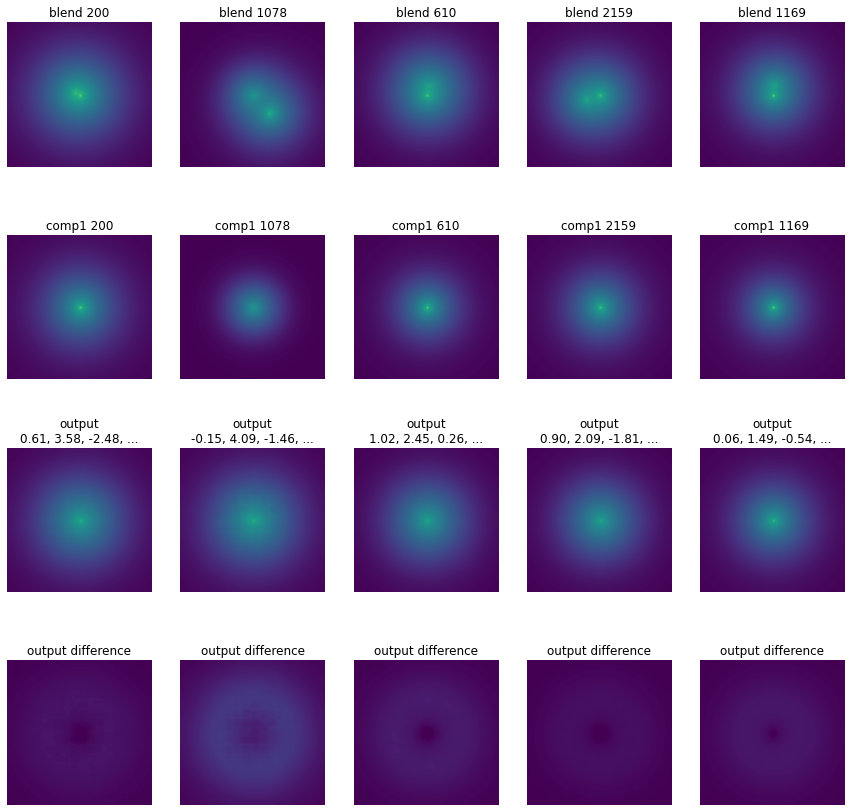

In [80]:
chosen=summary_plot(n,together,decode)

1/1 [==============================] - 0s 998us/step - loss: 0.0559 - mse_loss: 0.0217 - kl_loss: 0.0342


1/1 [==============================] - 0s 0s/step - loss: 0.0799 - mse_loss: 0.0411 - kl_loss: 0.0388


1/1 [==============================] - 0s 997us/step - loss: 0.0882 - mse_loss: 0.0580 - kl_loss: 0.0302


1/1 [==============================] - 0s 997us/step - loss: 0.0532 - mse_loss: 0.0231 - kl_loss: 0.0301


1/1 [==============================] - 0s 1ms/step - loss: 0.0503 - mse_loss: 0.0229 - kl_loss: 0.0274


1/1 [==============================] - 0s 997us/step - loss: 0.5844 - mse_loss: 0.5535 - kl_loss: 0.0309


1/1 [==============================] - 0s 1ms/step - loss: 0.0863 - mse_loss: 0.0536 - kl_loss: 0.0327


1/1 [==============================] - 0s 1ms/step - loss: 0.0951 - mse_loss: 0.0637 - kl_loss: 0.0315


1/1 [==============================] - 0s 997us/step - loss: 0.0648 - mse_loss: 0.0322 - kl_loss: 0.0326


1/1 [==============================] - 0s 997us/step - loss: 0.1040 - mse_loss: 0.0750 - kl_loss: 0.0291


1/1 [==============================] - 0s 1ms/step - loss: 0.0409 - mse_loss: 0.0092 - kl_loss: 0.0317


1/1 [==============================] - 0s 1ms/step - loss: 0.2389 - mse_loss: 0.1945 - kl_loss: 0.0444


1/1 [==============================] - 0s 997us/step - loss: 0.0490 - mse_loss: 0.0216 - kl_loss: 0.0274


1/1 [==============================] - 0s 997us/step - loss: 0.0915 - mse_loss: 0.0588 - kl_loss: 0.0327


1/1 [==============================] - 0s 1ms/step - loss: 0.6113 - mse_loss: 0.5758 - kl_loss: 0.0354


1/1 [==============================] - 0s 1ms/step - loss: 0.1173 - mse_loss: 0.0883 - kl_loss: 0.0290


1/1 [==============================] - 0s 1ms/step - loss: 0.0422 - mse_loss: 0.0074 - kl_loss: 0.0348


1/1 [==============================] - 0s 998us/step - loss: 0.1510 - mse_loss: 0.1063 - kl_loss: 0.0447


1/1 [==============================] - 0s 1ms/step - loss: 0.0947 - mse_loss: 0.0584 - kl_loss: 0.0363


1/1 [==============================] - 0s 1ms/step - loss: 0.1116 - mse_loss: 0.0827 - kl_loss: 0.0290


1/1 [==============================] - 0s 997us/step - loss: 0.5898 - mse_loss: 0.5628 - kl_loss: 0.0270


1/1 [==============================] - 0s 998us/step - loss: 0.0542 - mse_loss: 0.0241 - kl_loss: 0.0301


1/1 [==============================] - 0s 1ms/step - loss: 0.1788 - mse_loss: 0.1444 - kl_loss: 0.0344


1/1 [==============================] - 0s 1ms/step - loss: 0.0687 - mse_loss: 0.0383 - kl_loss: 0.0304


1/1 [==============================] - 0s 1ms/step - loss: 0.2321 - mse_loss: 0.1816 - kl_loss: 0.0505


1/1 [==============================] - 0s 991us/step - loss: 0.1078 - mse_loss: 0.0782 - kl_loss: 0.0295


1/1 [==============================] - 0s 998us/step - loss: 0.1716 - mse_loss: 0.1209 - kl_loss: 0.0508


1/1 [==============================] - 0s 2ms/step - loss: 0.0644 - mse_loss: 0.0169 - kl_loss: 0.0475


1/1 [==============================] - 0s 979us/step - loss: 0.0382 - mse_loss: 0.0062 - kl_loss: 0.0320


1/1 [==============================] - 0s 997us/step - loss: 0.0419 - mse_loss: 0.0138 - kl_loss: 0.0282


1/1 [==============================] - 0s 1ms/step - loss: 0.3452 - mse_loss: 0.3068 - kl_loss: 0.0385


1/1 [==============================] - 0s 1ms/step - loss: 0.1456 - mse_loss: 0.1163 - kl_loss: 0.0292


1/1 [==============================] - 0s 2ms/step - loss: 0.2761 - mse_loss: 0.2382 - kl_loss: 0.0379


1/1 [==============================] - 0s 1ms/step - loss: 0.0879 - mse_loss: 0.0345 - kl_loss: 0.0535


1/1 [==============================] - 0s 2ms/step - loss: 0.0395 - mse_loss: 0.0051 - kl_loss: 0.0344


1/1 [==============================] - 0s 973us/step - loss: 1.0715 - mse_loss: 1.0368 - kl_loss: 0.0347


1/1 [==============================] - 0s 997us/step - loss: 0.1042 - mse_loss: 0.0736 - kl_loss: 0.0306


1/1 [==============================] - 0s 997us/step - loss: 0.2539 - mse_loss: 0.2173 - kl_loss: 0.0366


1/1 [==============================] - 0s 998us/step - loss: 0.0885 - mse_loss: 0.0596 - kl_loss: 0.0289


1/1 [==============================] - 0s 997us/step - loss: 0.4523 - mse_loss: 0.4174 - kl_loss: 0.0349


1/1 [==============================] - 0s 997us/step - loss: 0.0564 - mse_loss: 0.0286 - kl_loss: 0.0278


1/1 [==============================] - 0s 998us/step - loss: 0.1478 - mse_loss: 0.1197 - kl_loss: 0.0281


1/1 [==============================] - 0s 997us/step - loss: 0.0441 - mse_loss: 0.0144 - kl_loss: 0.0297


1/1 [==============================] - 0s 2ms/step - loss: 1.1378 - mse_loss: 1.1103 - kl_loss: 0.0276


1/1 [==============================] - 0s 1ms/step - loss: 0.1038 - mse_loss: 0.0520 - kl_loss: 0.0518


1/1 [==============================] - 0s 2ms/step - loss: 0.2100 - mse_loss: 0.1822 - kl_loss: 0.0279


1/1 [==============================] - 0s 969us/step - loss: 0.0478 - mse_loss: 0.0193 - kl_loss: 0.0286


1/1 [==============================] - 0s 997us/step - loss: 0.0463 - mse_loss: 0.0167 - kl_loss: 0.0295


1/1 [==============================] - 0s 998us/step - loss: 0.1594 - mse_loss: 0.1313 - kl_loss: 0.0281


1/1 [==============================] - 0s 1ms/step - loss: 0.0600 - mse_loss: 0.0195 - kl_loss: 0.0405


1/1 [==============================] - 0s 997us/step - loss: 0.2490 - mse_loss: 0.2173 - kl_loss: 0.0318


1/1 [==============================] - 0s 0s/step - loss: 0.2342 - mse_loss: 0.1907 - kl_loss: 0.0435


(Text(0.5, 0, 'Loss'), Text(0, 0.5, 'Frequency'))

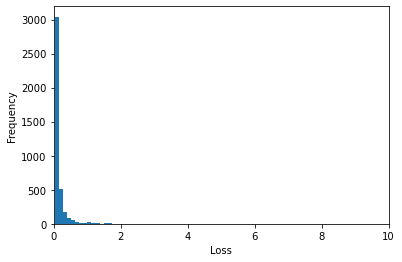

In [81]:
losses=np.zeros(num)
for ite in range(0,num):
    input_img=blended[ite]
    compc=components[0,ite]

    input_img=input_img.reshape(1,height,width,1).astype('float32')
    compc=compc.reshape(1,height,width,1).astype('float32')

    evals=vae.evaluate([input_img,compc],verbose=1,batch_size=batch_size)
    losses[ite]=evals[0]
    #print(ite)
    
#fig=plt.figure()
ax=plt.axes()
ax.hist(losses,bins=50)
ax.set_xlim(0,10),ax.set_ylim(0)
ax.set_xlabel("Loss"),ax.set_ylabel("Frequency")